In [1]:
#imports
import pandas as pd
from IPython.display import display
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import StratifiedKFold
import warnings
import deepchem as dc
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from DeepPurpose import utils, dataset, CompoundPred
import exmol

# Configuring warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=UserWarning, message='.*X does not have valid feature names.*')

from utils.canonicalize import *
from utils.featgen import *
from utils.samplers import *
from utils.plots import *
from utils.rfcv import *
from utils.models_config import *

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
c:\Users\stebi\anaconda3\Lib\site-packages\transformers\adapters\__init__.py:27: FutureWarning: The `adapter-transformers` package is deprecated and replaced by the `adapters` package. See https://docs.adapterhub.ml/transitioning.html.
  warnings.warn(
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (c:\Users\stebi\anaconda3\Lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


### Import datasets and initial preprocessing

In [2]:
df = pd.read_csv(r"./data/train.csv")
test = pd.read_csv(r"./data/test.csv")

In [3]:
df

smiles  BBB
0          C[N+]1(C)CCC(OC(=O)C(O)(c2ccccc2)C2CCCC2)C1    0
1        C[N+]1(C)CCCC(OC(=O)C(O)(c2ccccc2)c2ccccc2)C1    0
2     C[N+]12CCC(CC1)C(OC(=O)C(O)(c1ccccc1)c1ccccc1)C2    0
3      CC(C)[N+](C)(CCOC(=O)C1c2ccccc2Oc2ccccc21)C(C)C    0
4         CC(C)[N+]1(C)C2CCC1CC(OC(=O)C(CO)c1ccccc1)C2    0
...                                                ...  ...
1932    OCCN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc32)CC1    1
1933                               O=C(NCc1ccccc1)OCCO    1
1934                            S=P(N1CC1)(N1CC1)N1CC1    1
1935                S=C(NC1CCCCC1)N1CCC(c2cnc[nH]2)CC1    1
1936                 O=C1CC2SC(C3(O)CN4C(=O)CC4S3)CN12    1

[1937 rows x 2 columns]

In [4]:
test

smiles  BBB
0    [H]C([H])([H])Oc1ccc(-n2nc3c4ccc(OC([H])([H])[...    1
1    [H]C([H])([H])Oc1ccc2c3nn(-c4ccc(OC)cc4)c(=O)c...    1
2    [H]C([H])([H])Oc1ccccc1-n1nc2c3cc(Cl)ccc3[nH]c...    1
3                                                 [Ar]    1
4                     Nc1nc2c(ncn2COC(CO)CO)c(=O)[nH]1    1
..                                                 ...  ...
522                         CNC(=NC#N)NCCSCc1[nH]cnc1C    0
523            CN=C(C[N+](=O)[O-])NCCSCc1ccc(CN(C)C)o1    0
524                                              S=C=S    1
525                   CN(C)CCCN1c2ccccc2S(=O)c2ccccc21    1
526                                  Cc1csc(NC(=N)N)n1    1

[527 rows x 2 columns]

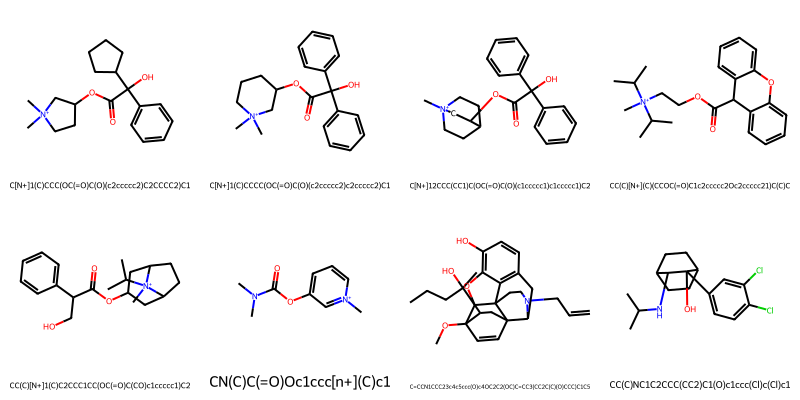

In [5]:
first_four_smiles = df['smiles'].head(8).tolist()
molecules = [Chem.MolFromSmiles(smile) for smile in first_four_smiles]
img = Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(200, 200), legends=first_four_smiles)
display(img)

In [6]:
df = canonicalize_smiles(df, smiles_col='smiles') 
test = canonicalize_smiles(test, smiles_col='smiles') 
duplicate_groups = df[df.duplicated(subset=['smiles'], keep=False)].groupby('smiles')
duplicate_groups = test[test.duplicated(subset=['smiles'], keep=False)].groupby('smiles')
df = df.drop_duplicates(subset='smiles', keep=False)
test = test.drop_duplicates(subset='smiles', keep=False)

### Feature generation for both df

In [7]:
feature_types = ['morgan', 'pubchem', 'rdkit2d', 'maccs', 'daylight', 'physchem']

df = add_molecular_features(df, smiles_col='smiles', feature_types=feature_types)
df = df.rename(columns={'SMILES': 'smiles'})

test = add_molecular_features(test, smiles_col='smiles', feature_types=feature_types)
test = test.rename(columns={'SMILES': 'smiles'})

In [8]:
if set(df.columns) == set(test.columns):
    print("Feature names in both DataFrames are identical.")
else:
    print("Feature names differ.")

    features_only_in_df = set(df.columns) - set(test.columns)
    features_only_in_test = set(test.columns) - set(df.columns)

    if features_only_in_df:
        print("Features only in df:", features_only_in_df)
    if features_only_in_test:
        print("Features only in test:", features_only_in_test)

Feature names in both DataFrames are identical.


### Random samplers to tackel class imbalance


In [9]:
X, y, smiles = prepare_data(df)
df_rus = under_sample(X, y, smiles)
df_ros = over_sample(X, y, smiles)

print("Original class distribution:")
print(df['BBB'].value_counts())
print("Random Under-Sampling class distribution:")
print(df_rus['BBB'].value_counts())
print("\nRandom Over-Sampling class distribution:")
print(df_ros['BBB'].value_counts())

Original class distribution:
1    1476
0     461
Name: BBB, dtype: int64
Random Under-Sampling class distribution:
0    461
1    461
Name: BBB, dtype: int64

Random Over-Sampling class distribution:
0    1476
1    1476
Name: BBB, dtype: int64


### t-SNE

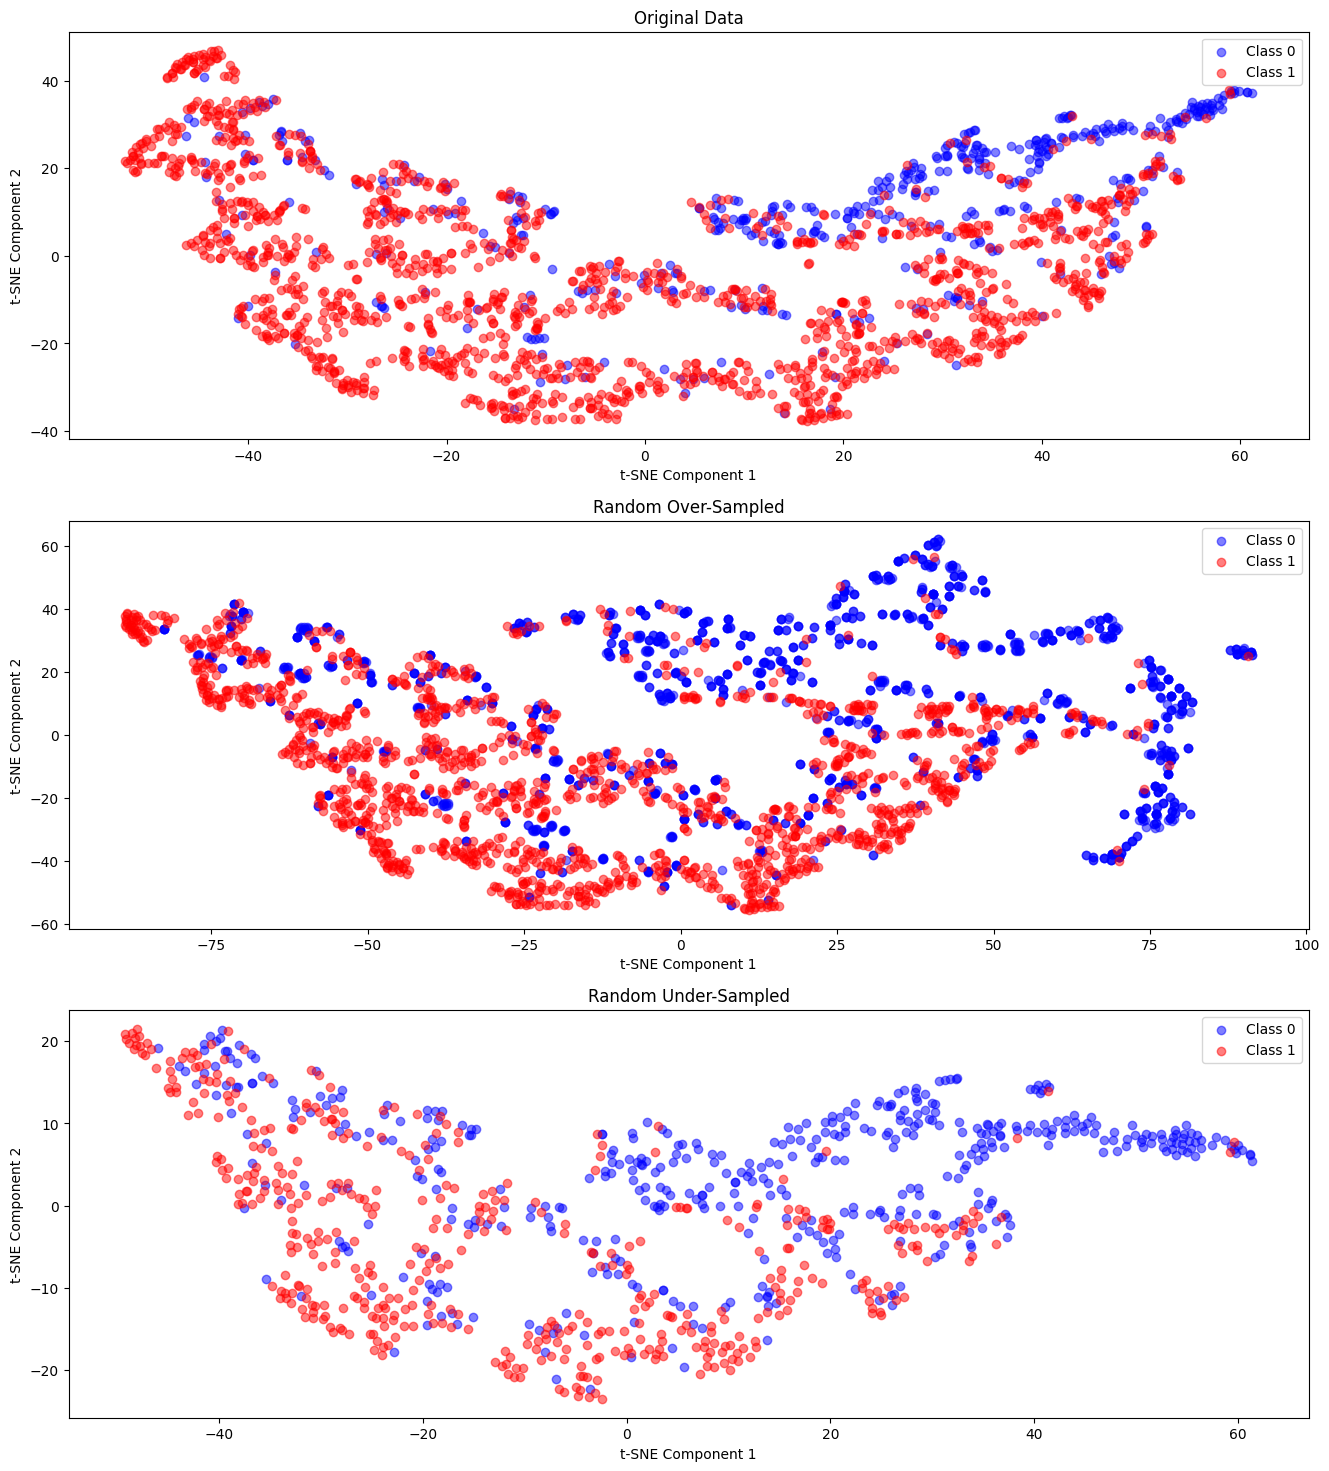

In [10]:
dfs = [df, df_ros, df_rus]
titles = ['Original Data', 'Random Over-Sampled', 'Random Under-Sampled']
plot_tsne(dfs, titles)

In [11]:
df_sel = df
df_rus_sel = df_rus
df_ros_sel = df_ros

### Baseline models

In [12]:
dfs = {
    'Imbalanced df': df,
    'Randomly undersampled df': df_rus,
    'Randomly oversampled df': df_ros
}

n_splits = 5  
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

trained_models = {}

for df_name, selected_df in dfs.items():
    feature_cols = selected_df.drop(['BBB', 'smiles'], axis=1).columns
    X = selected_df[feature_cols]
    y = selected_df['BBB']
    print(f"\nValidating models on {df_name}:")
    
    trained_models[df_name] = {}

    for name, model in models.items():
        fold_acc = [] 

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            model_clone = clone(model)
            model_clone.fit(X_train, y_train)
            y_pred = model_clone.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            fold_acc.append(accuracy)

        avg_accuracy = sum(fold_acc) / len(fold_acc)
        print(f"  Model: {name}, Average Accuracy: {avg_accuracy:.4f}")
        
        trained_models[df_name][name] = model_clone


Validating models on Imbalanced df:
  Model: Logistic Regression, Average Accuracy: 0.9014
  Model: Decision Tree, Average Accuracy: 0.8508
  Model: Random Forest, Average Accuracy: 0.9112
  Model: Gradient Boosting, Average Accuracy: 0.8978
  Model: k-Nearest Neighbors, Average Accuracy: 0.8642
  Model: Naive Bayes, Average Accuracy: 0.7465

Validating models on Randomly undersampled df:
  Model: Logistic Regression, Average Accuracy: 0.8536
  Model: Decision Tree, Average Accuracy: 0.7929
  Model: Random Forest, Average Accuracy: 0.8721
  Model: Gradient Boosting, Average Accuracy: 0.8568
  Model: k-Nearest Neighbors, Average Accuracy: 0.7972
  Model: Naive Bayes, Average Accuracy: 0.7647

Validating models on Randomly oversampled df:
  Model: Logistic Regression, Average Accuracy: 0.9133
  Model: Decision Tree, Average Accuracy: 0.9319
  Model: Random Forest, Average Accuracy: 0.9695
  Model: Gradient Boosting, Average Accuracy: 0.9326
  Model: k-Nearest Neighbors, Average Accuracy

### Test trained models on exogenous dataset

In [13]:
features_ex = test.drop(columns=['BBB', 'smiles']).values
targets_ex = test['BBB'].values
smiles_ex = test['smiles'].values

valid_indices = validate_and_filter_smiles(smiles_ex)
valid_features_ex = features_ex[valid_indices]
valid_targets_ex = targets_ex[valid_indices]
valid_smiles_ex = smiles_ex[valid_indices]

test_dataset = dc.data.NumpyDataset(X=valid_features_ex, y=valid_targets_ex, ids=valid_smiles_ex)
sp(dc.splits.ScaffoldSplitter(), test_dataset)

def test_exogenous_models(trained_models, test_dataset, set_name="Test Set"):
    test_scores = {}
    for df_name, models_dict in trained_models.items():
        test_scores[df_name] = {}
        for model_name, model in models_dict.items():
            y_pred = model.predict(test_dataset.X)
            accuracy = dc.metrics.accuracy_score(test_dataset.y, y_pred)
            test_scores[df_name][model_name] = accuracy
    return test_scores

exogenous_test_scores = test_exogenous_models(trained_models, test_dataset)

def print_scores(scores, set_name):
    print(f"\n{set_name} Results:")
    for df_name, results in scores.items():
        print(f"\n  {df_name}:")
        for model_name, accuracy in results.items():
            print(f"    {model_name}: {accuracy:.4f}")

print_scores(exogenous_test_scores, "Exogenous Test Set")


[06:56:44] Explicit valence for atom # 8 C greater than permitted



Exogenous Test Set Results:

  Imbalanced df:
    Logistic Regression: 0.8686
    Decision Tree: 0.7314
    Random Forest: 0.8857
    Gradient Boosting: 0.8857
    k-Nearest Neighbors: 0.8362
    Naive Bayes: 0.6857

  Randomly undersampled df:
    Logistic Regression: 0.7962
    Decision Tree: 0.7676
    Random Forest: 0.8419
    Gradient Boosting: 0.8286
    k-Nearest Neighbors: 0.7390
    Naive Bayes: 0.6933

  Randomly oversampled df:
    Logistic Regression: 0.8400
    Decision Tree: 0.7981
    Random Forest: 0.8952
    Gradient Boosting: 0.8610
    k-Nearest Neighbors: 0.7600
    Naive Bayes: 0.7143


### AUC curve for baseline

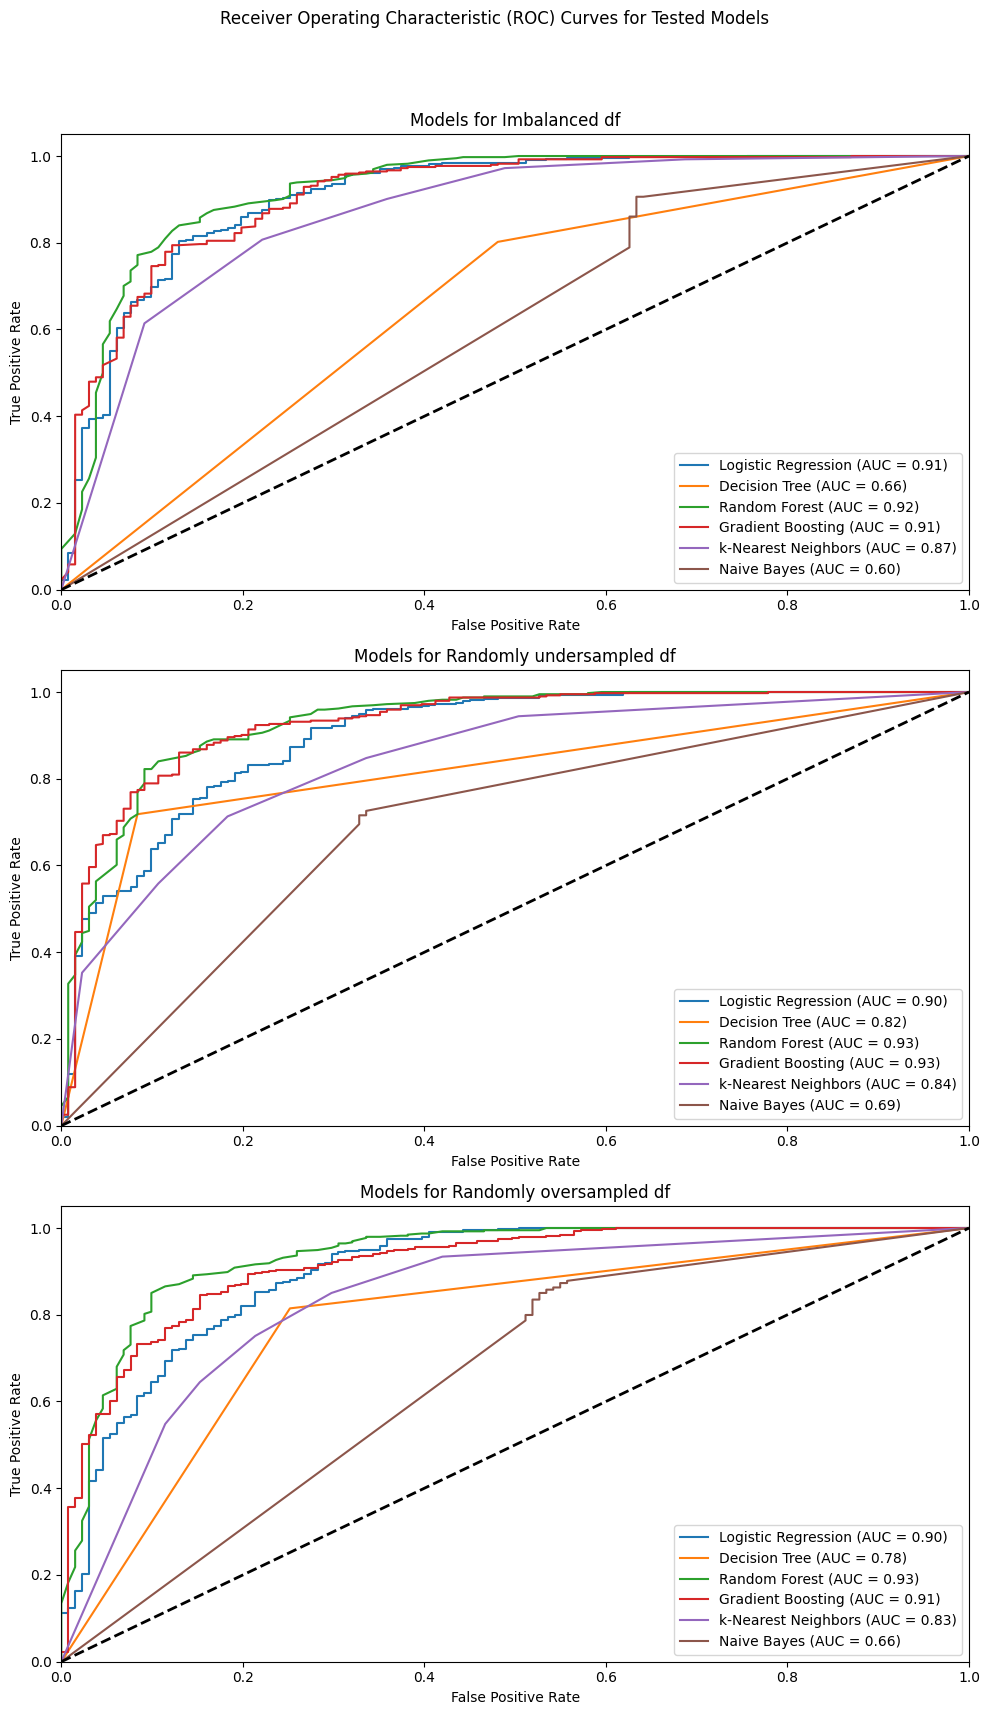

In [14]:
plot_roc_curves(trained_models, test_dataset)

### XAI

In [15]:
#feature selection
df_sel = apply_RFECV_and_add(df_rus)

In [16]:
#creating 3 splits of test with same features
#columns_df_sel = df_sel.columns
#test_sel = test[columns_df_sel]

In [17]:
X_drugs = df_sel['smiles'].tolist()
y = df_sel['BBB'].tolist()
drug_encoding = 'Morgan'

train, val, test = utils.data_process(X_drug = X_drugs, y=y, drug_encoding=drug_encoding, split_method = 'random, frac=[0.7,0.1,0.2]')

Drug Property Prediction Mode...
in total: 922 drugs
encoding drug...
unique drugs: 922
Done.


Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69235. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.80661 , AUPRC: 0.79621 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.69140. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.90212 , AUPRC: 0.89416 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.67710. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.93380 , AUPRC: 0.92586 , F1: 0.64705
Training at Epoch 4 iteration 0 with loss 0.51350. Total time 0.0 hours
Validation at Epoch 4 , AUROC: 0.94137 , AUPRC: 0.92904 , F1: 0.84705
Training at Epoch 5 iteration 0 with loss 0.26376. Total time 0.0 hours
Validation at Epoch 5 , AUROC: 0.94137 , AUPRC: 0.93010 , F1: 0.83333
Training at Epoch 6 iteration 0 with loss 0.07675. Total time 0.0 hours
Validation at Epoch 6 , AUROC: 0.93522 , AUPRC: 0.92254 , F1: 0.84782
Training at Epoch 7 iteration 0 with loss 0.19385. Total time 0.00027 hours
Validation at 

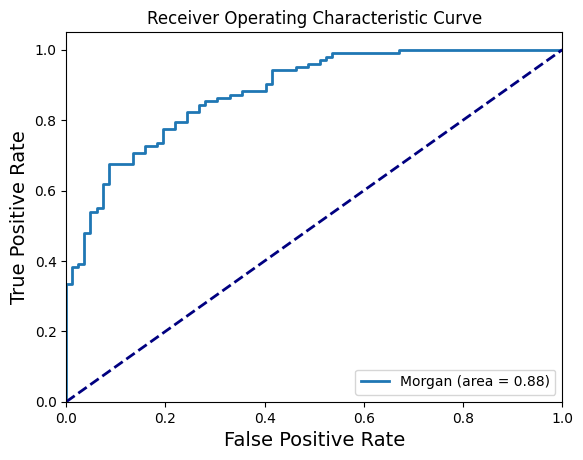

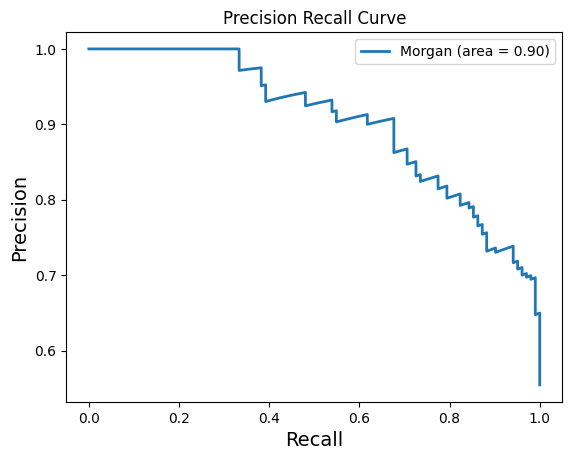

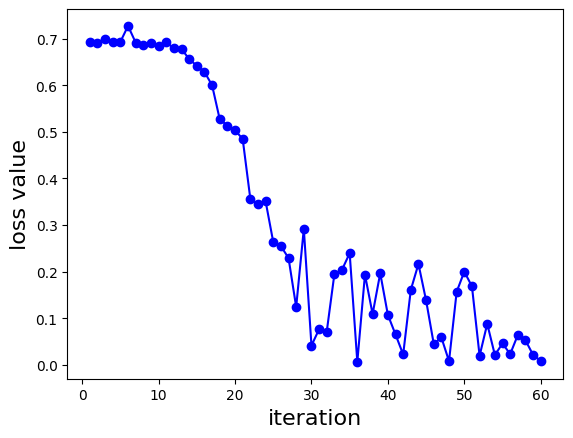

In [18]:
config = utils.generate_config(drug_encoding=drug_encoding,
mlp_hidden_dims_drug=[32, 8],
train_epoch=10,
LR=0.001,
batch_size=128)
model = CompoundPred.model_initialize(**config)
model.train(train, val, test)

In [19]:
def predictor(smiles):
    X_drug = [smiles]
    X_pred = utils.data_process(X_drug=X_drug, y=y, drug_encoding=drug_encoding,
                                split_method = 'no_split')
    y_pred = model.predict(X_pred)
    print('The precicted score is' + str(y_pred))
    answ = 1 if y_pred[0] > 0.5 else 0
    return answ

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.05693402513861656]


😀Calling your model function😀: 100%|██████████| 3000/3000 [00:04<00:00, 752.51it/s]

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.14142806828022003]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7372375726699829]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.05136607587337494]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.6677581667900085]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precict

🔭Projecting...🔭:   0%|          | 0/2662 [00:00<?, ?it/s]                          

The precicted score is[0.7552251815795898]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.07119947671890259]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.03500058501958847]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.731755256652832]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.6493268609046936]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for alrea

🤘Done🤘: 100%|██████████| 2662.0/2662 [00:10<00:00, 266.01it/s]          


SMARTS annotations for MACCS descriptors were created using SMARTSviewer (smartsview.zbh.uni-hamburg.de, Copyright: ZBH, Center for Bioinformatics Hamburg) developed by K. Schomburg et. al. (J. Chem. Inf. Model. 2010, 50, 9, 1529–1535)
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.22016239166259766]


😀Calling your model function😀: 100%|██████████| 3000/3000 [00:04<00:00, 731.18it/s]

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.15222011506557465]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.0069169700145721436]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.22016239166259766]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.22818955779075623]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The pre

🔭Projecting...🔭:   0%|          | 0/2542 [00:00<?, ?it/s]                          

The precicted score is[0.12832669913768768]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.24497632682323456]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.28316938877105713]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7068520784378052]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.5783766508102417]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for alr

🤘Done🤘: 100%|██████████| 2542.0/2542 [00:08<00:00, 304.19it/s]          


SMARTS annotations for MACCS descriptors were created using SMARTSviewer (smartsview.zbh.uni-hamburg.de, Copyright: ZBH, Center for Bioinformatics Hamburg) developed by K. Schomburg et. al. (J. Chem. Inf. Model. 2010, 50, 9, 1529–1535)
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7220375537872314]


😀Calling your model function😀: 100%|██████████| 3000/3000 [00:00<00:00, 4626.90it/s]

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7102522253990173]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7123159766197205]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7074195146560669]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.6950575113296509]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted

🥰Finishing up🥰: 100%|██████████| 371.0/371 [00:00<00:00, 5477.48it/s]               

The precicted score is[0.36823874711990356]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7142439484596252]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7125624418258667]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.6558120846748352]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7095527052879333]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for alrea

🤘Done🤘: 100%|██████████| 371.0/371 [00:00<00:00, 2439.45it/s]        


SMARTS annotations for MACCS descriptors were created using SMARTSviewer (smartsview.zbh.uni-hamburg.de, Copyright: ZBH, Center for Bioinformatics Hamburg) developed by K. Schomburg et. al. (J. Chem. Inf. Model. 2010, 50, 9, 1529–1535)


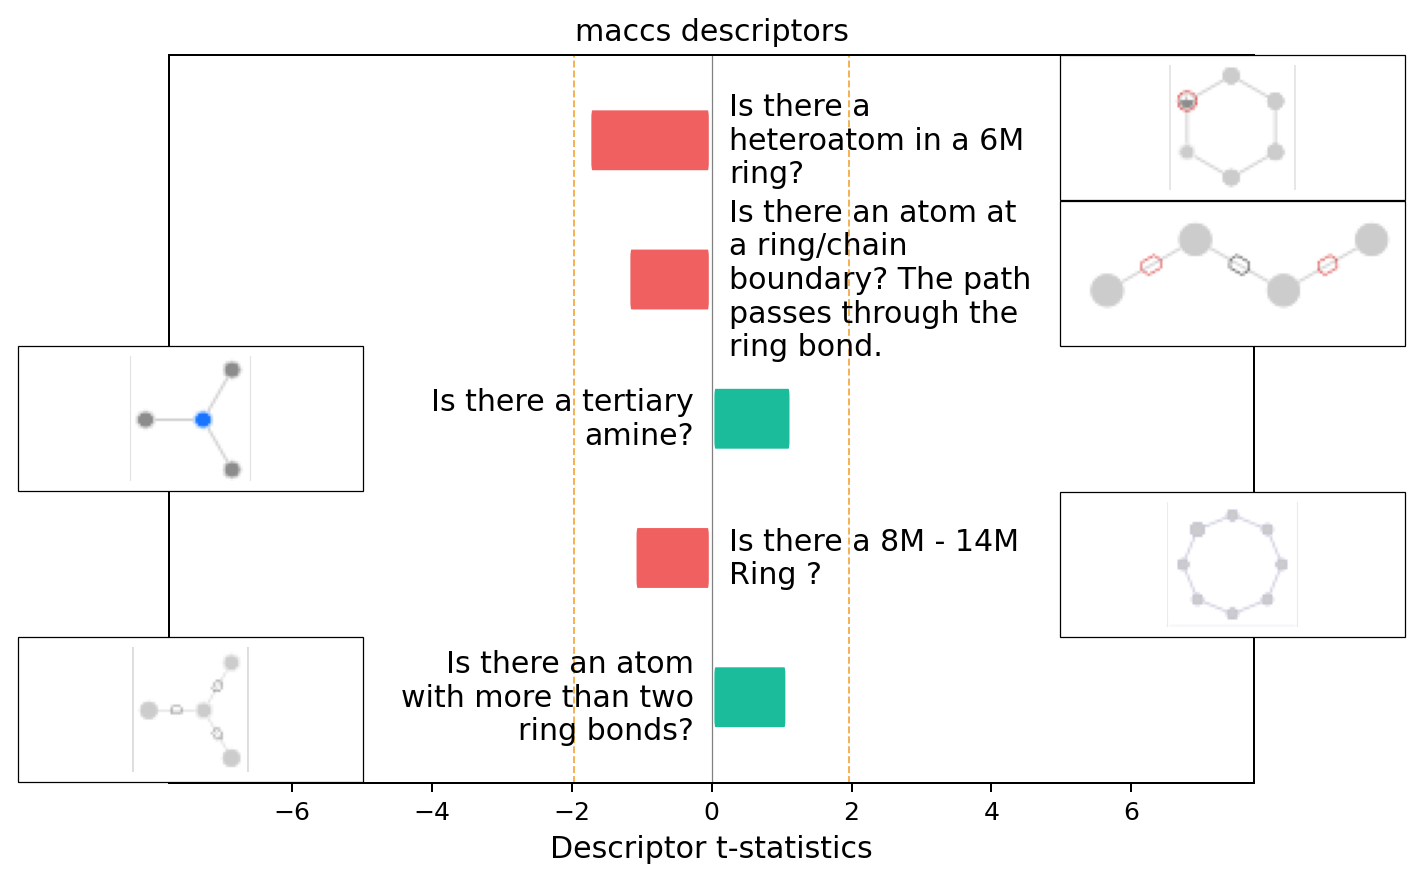

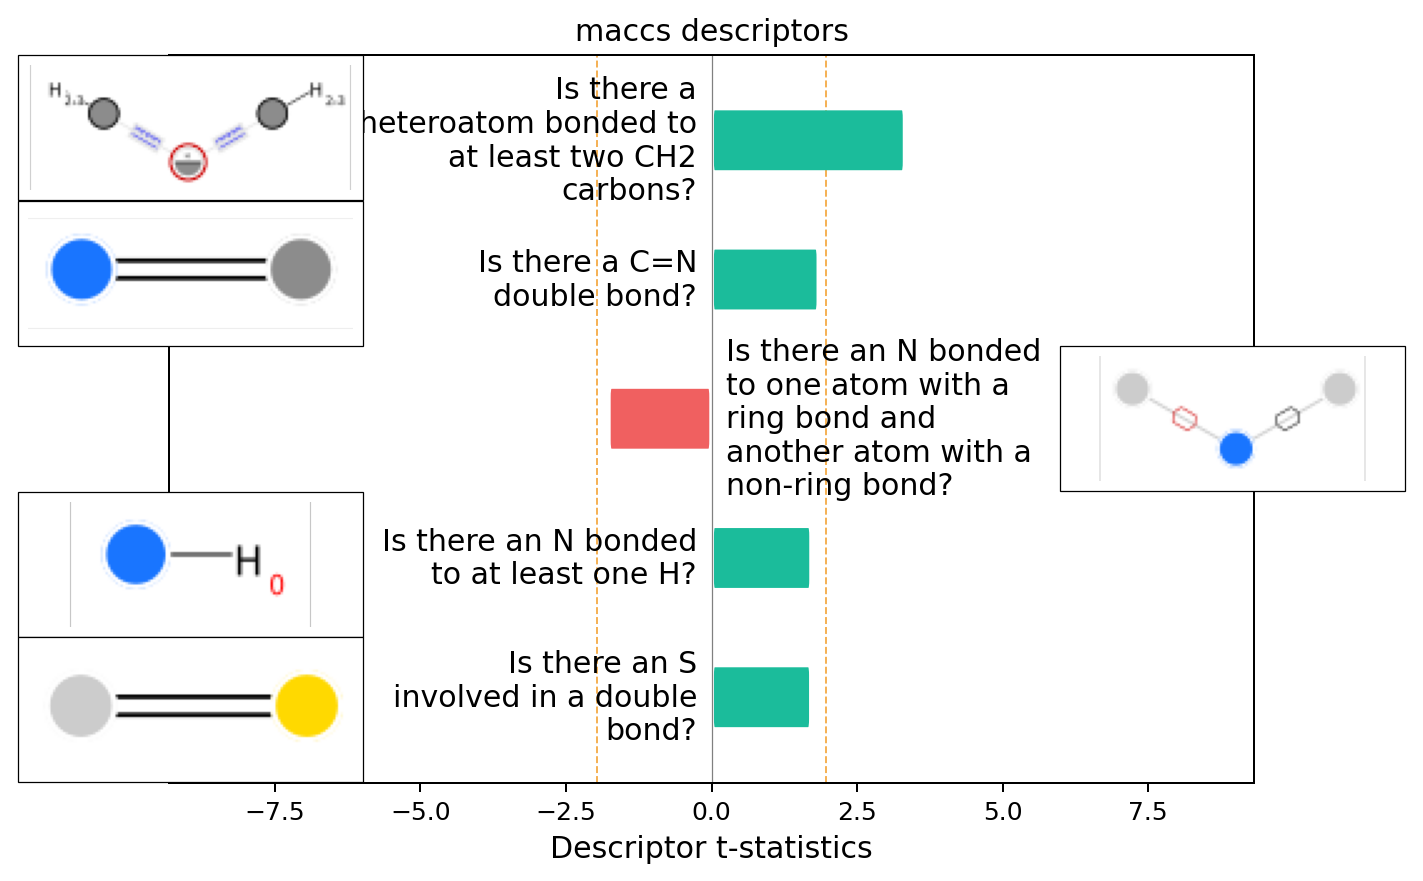

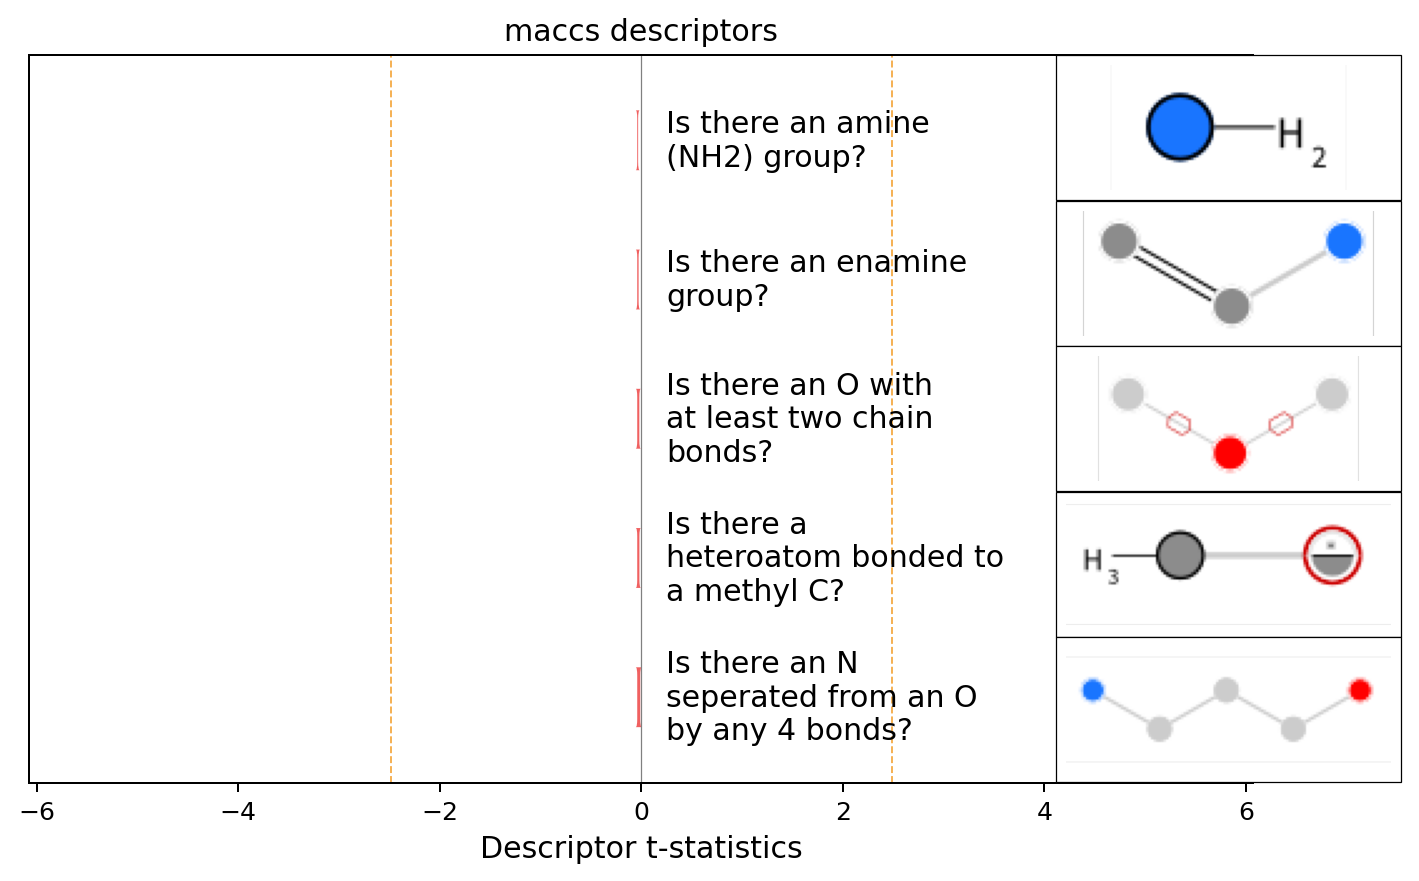

In [21]:
smiles_list = [
    "[H]C([H])([H])Oc1ccc(-n2nc3c4ccc(OC([H])([H])[H])cc4[nH]cc-3c2=O)cc1",
    "C[N+]1(C)CCCC(OC(=O)[C+](O)(c2ccccc2)c2ccccc2)C1",
    "C=CC#N"
]

for smiles in smiles_list:
    space = exmol.sample_space(smiles, predictor, batched=False)
    beta = exmol.lime_explain(space, descriptor_type='MACCS', return_beta=True)
    exmol.plot_descriptors(space, output_file=f'MACCS_{smiles}.svg')

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.05693402513861656]


😀Calling your model function😀: 100%|██████████| 3000/3000 [00:05<00:00, 702.35it/s]

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.2367270290851593]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.21923787891864777]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.05214232951402664]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7131274342536926]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precict

🤘Done🤘: 100%|██████████| 2686.0/2686 [00:11<00:00, 226.07it/s]                     


Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.22016239166259766]


😀Calling your model function😀: 100%|██████████| 3000/3000 [00:05<00:00, 660.57it/s]

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.19232730567455292]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.717336118221283]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.4508591592311859]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.005733706057071686]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precict

😀Calling your model function😀: 100%|██████████| 3000/3000 [00:14<00:00, 660.57it/s]

The precicted score is[0.01894407719373703]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.061204537749290466]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.05674514174461365]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.026009170338511467]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.025583680719137192]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data fo

🔭Projecting...🔭:  13%|█▎        | 316.5/2531 [00:00<00:00, 3137.67it/s]            

The precicted score is[0.39258745312690735]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7246790528297424]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.06082986667752266]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.30875325202941895]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7655860185623169]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for alr

🤘Done🤘: 100%|██████████| 2531.0/2531 [00:10<00:00, 251.75it/s]          


Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7220375537872314]


😀Calling your model function😀: 100%|██████████| 3000/3000 [00:00<00:00, 3856.15it/s]

Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.6950575113296509]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7229246497154236]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7051622867584229]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7220375537872314]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted

🔭Projecting...🔭:   0%|          | 0/360 [00:00<?, ?it/s]                            

do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7161372303962708]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7247074842453003]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.695754885673523]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.5340254902839661]
Drug Property Prediction Mode...
in total: 1 drugs
encoding drug...
unique drugs: 1
do not do train/test split on the data for already splitted data
predicting...
The precicted score is[0.7020195126533508]
Drug Property Prediction Mode...
in total: 1 drugs
enco

🤘Done🤘: 100%|██████████| 360.0/360 [00:00<00:00, 1259.30it/s]        


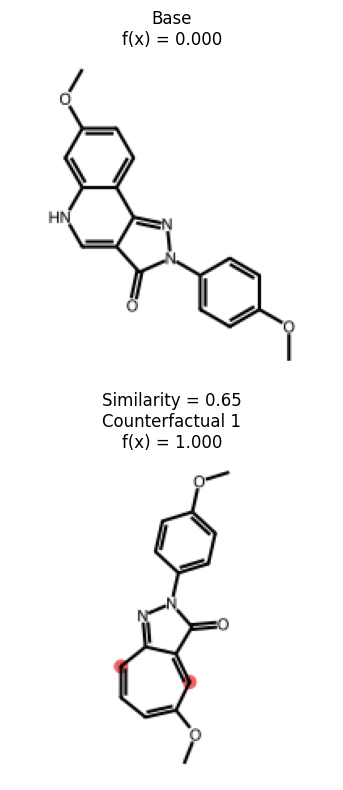

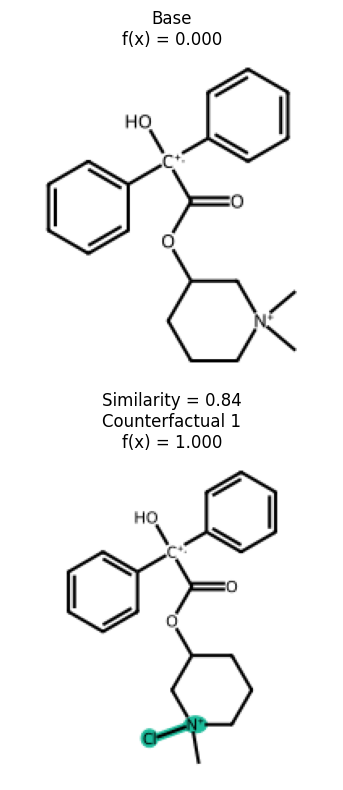

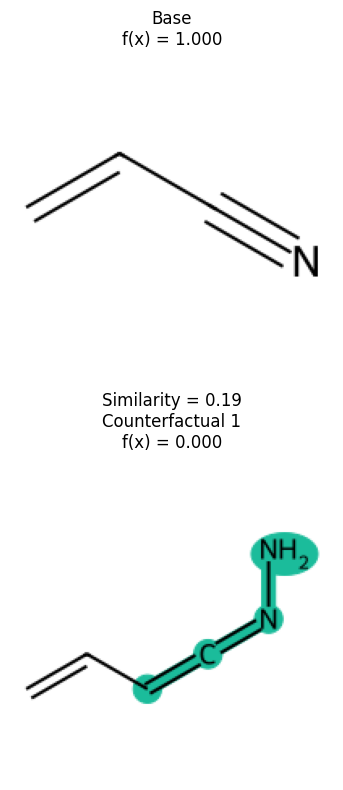

In [23]:
for smiles in smiles_list:
    space = exmol.sample_space(smiles, predictor, batched=False)
    cfs = exmol.cf_explain(space, 1)  
    exmol.plot_cf(cfs) 